In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import gc

from IPython.core.interactiveshell import InteractiveShell
import pandas as pd


from tpx3awkward._utils import (
    drop_zero_tot,
    cluster_df_optimized,
    group_indices,
    centroid_clusters,
    ingest_cent_data,
    add_centroid_cols,
    trim_corr_file,
    trim_corr,
    timewalk_corr,
    DEFAULT_CLUSTER_TW,
    DEFAULT_CLUSTER_RADIUS,
	raw_as_numpy,
	 ingest_raw_data,
)


InteractiveShell.ast_node_interactivity = "all"  # ustaw raz w notatniku

In [2]:


data_dir = Path('/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/Measurement_Nov_21_2025_16h20m39s/raw')
#data_dir = Path('/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/Measurement_Nov_21_2025_15h53m29s/raw')

filename_sufix = 'fGKd_000000'



# assert (test_sorted['x'].values == ref_sorted['#Col'].values).all()
# assert (test_sorted['y'].values == ref_sorted['#Row'].values).all()
# assert (test_sorted['ToT'].values == ref_sorted['#ToT[arb]'].values).all()
# assert (test_sorted['timestamp'].values == ref_sorted['#ToA'].values).all()

In [3]:
row_cutoff = 10**6
head_disp = 1000

In [4]:
fname = data_dir / f'{filename_sufix}.tpx3'

d = raw_as_numpy(fname)
test = pd.DataFrame(ingest_raw_data(d)).reset_index()

del d
gc.collect()

test['x']=test['x']-256


test_sorted = (
    test.sort_values(['t','ToT','x','y'])
        .astype({'t': np.int64})
        .reset_index(drop=True)
)

test_sorted['index'] = test_sorted.index
test_sorted = test_sorted.iloc[:row_cutoff].copy()


del test
gc.collect()

7

0

In [5]:
test_sorted

,index,x,y,ToT,t,chip
0,0,106,130,300,441928,0
1,1,123,129,150,441936,0
2,2,170,98,1500,442178,0
3,3,171,99,1750,442178,0
4,4,171,98,2325,442178,0
...,...,...,...,...,...,...
999995,999995,124,126,475,240064009,0
999996,999996,124,125,350,240064025,0
999997,999997,118,146,300,240064038,0
999998,999998,122,125,200,240064062,0


In [6]:
test_sorted['x'].describe()

count    1000000.000000
mean         123.648833
std           37.369130
min            0.000000
25%          116.000000
50%          123.000000
75%          130.000000
max          255.000000
Name: x, dtype: float64

In [25]:
radius

3

In [7]:
# Cluster (tw in timestamp units, radius in pixels)
tw = DEFAULT_CLUSTER_TW          # or custom (e.g. 3000)
radius = DEFAULT_CLUSTER_RADIUS  # or custom (e.g. 3)
cluster_labels, events = cluster_df_optimized(test_sorted, tw=tw, radius=radius)
test_sorted["cluster_id"] = cluster_labels

# Build cluster index matrix
cluster_array = group_indices(cluster_labels)

# Centroid computation
cent_data = centroid_clusters(cluster_array, events)
cent_df = pd.DataFrame(ingest_cent_data(cent_data)).sort_values("t").reset_index(drop=True)

# Add rounded pixel coordinates and ns timestamps
cent_df = add_centroid_cols(cent_df, gap=True)

# cent_df now has columns: t (raw ticks), xc,yc (float), x,y (uint16), t_ns (nanoseconds), ToT_max, ToT_sum, n
test_sorted.head()
cent_df.head()

   index    x    y   ToT       t  chip  cluster_id
0      0  106  130   300  441928     0           0
1      1  123  129   150  441936     0           1
2      2  170   98  1500  442178     0           2
3      3  171   99  1750  442178     0           2
4      4  171   98  2325  442178     0           2
        t          xc          yc  ToT_max  ToT_sum  n    x    y        t_ns
0  441928  106.000000  130.000000      300      300  1  106  130  690512.500
1  441936  123.000000  129.000000      150      150  1  123  129  690525.000
2  442178  170.631790   98.406975     2325     6450  4  171   98  690903.125
3  442478  126.811798  112.856743     5075     8900  6  127  113  691371.875
4  443778  128.578308  129.626511     1550     4150  4  129  130  693403.125


In [8]:
test_sorted.head()
cent_df.head()

,index,x,y,ToT,t,chip,cluster_id
0,0,106,130,300,441928,0,0
1,1,123,129,150,441936,0,1
2,2,170,98,1500,442178,0,2
3,3,171,99,1750,442178,0,2
4,4,171,98,2325,442178,0,2


,t,xc,yc,ToT_max,ToT_sum,n,x,y,t_ns
0,441928,106.000000,130.000000,300,300,1,106,130,690512.500
1,441936,123.000000,129.000000,150,150,1,123,129,690525.000
2,442178,170.631790,98.406975,2325,6450,4,171,98,690903.125
3,442478,126.811798,112.856743,5075,8900,6,127,113,691371.875
4,443778,128.578308,129.626511,1550,4150,4,129,130,693403.125


In [21]:
cent_df

,t,xc,yc,ToT_max,ToT_sum,n,x,y,t_ns,dt,dr
0,441928,106.000000,130.000000,300,300,1,106,130,6.905125e+05,NaN,NaN
1,441936,123.000000,129.000000,150,150,1,123,129,6.905250e+05,8.0,17.029386
2,442178,170.631790,98.406975,2325,6450,4,171,98,6.909031e+05,242.0,57.140179
3,442478,126.811798,112.856743,5075,8900,6,127,113,6.913719e+05,300.0,46.486557
4,443778,128.578308,129.626511,1550,4150,4,129,130,6.934031e+05,1300.0,17.117243
...,...,...,...,...,...,...,...,...,...,...,...
187598,240063108,109.187500,133.156250,525,800,3,109,133,3.750986e+08,985.0,16.278821
187599,240063110,141.000000,118.000000,800,800,1,141,118,3.750986e+08,2.0,35.341194
187600,240063985,113.096298,112.362961,5075,10125,6,113,112,3.751000e+08,875.0,28.635642
187601,240064001,123.102562,125.589745,2275,4875,6,123,126,3.751000e+08,16.0,17.204651


In [17]:
import numpy as np

def tot_image(cent_df, scale=1, value_col="ToT_max", dtype=np.uint64):
    """
    Build a 2D array of summed values (default ToT_max) from centroid dataframe.
    scale=1 -> 256x256, scale=2 -> 512x512, etc.
    """
    base_size = 256
    size = base_size * scale
    img = np.zeros((size, size), dtype=dtype)

    # Extract coordinates and values
    xc = cent_df["xc"].to_numpy()
    yc = cent_df["yc"].to_numpy()
    vals = cent_df[value_col].to_numpy(dtype=dtype)

    # Scale then round to nearest integer pixel
    x_idx = np.rint(xc * scale).astype(int)
    y_idx = np.rint(yc * scale).astype(int)

    # Clip to valid range (in case rounding hits the border)
    x_idx = np.clip(x_idx, 0, size - 1)
    y_idx = np.clip(y_idx, 0, size - 1)

    # Accumulate (vectorized)
    np.add.at(img, (y_idx, x_idx), vals)
    return img

# Examples:
img_256 = tot_image(cent_df, scale=1)   # shape (256,256)
img_512 = tot_image(cent_df, scale=2)   # shape (512,512)
# Custom scale (e.g. half-pixel bins -> scale=2 for finer grid)

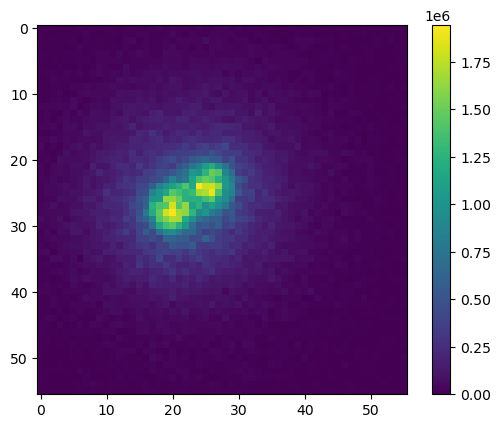

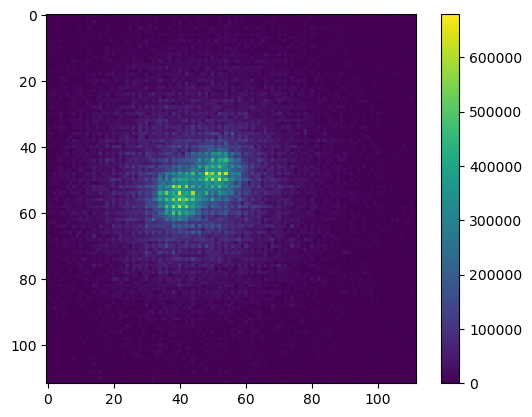

In [20]:
import matplotlib.pyplot as plt

slice2d_noscatt=(slice(100,156), slice(100,156))

plt.imshow(img_256[slice2d_noscatt])
plt.colorbar()
plt.show()

slice2d_noscatt_scale_2=(slice(200,312), slice(200,312))
plt.imshow(img_512[slice2d_noscatt_scale_2])
plt.colorbar()
plt.show()

In [15]:
cent_df['dt']=cent_df['t'].diff()

cent_df['dr']=np.sqrt(cent_df['x'].astype(np.int32).diff()**2+cent_df['y'].astype(np.int32).diff()**2)

In [ ]:
cent_df

In [5]:
test_sorted.info()
test_sorted.head(head_disp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   index   1000000 non-null  int64 
 1   x       1000000 non-null  uint16
 2   y       1000000 non-null  uint16
 3   ToT     1000000 non-null  uint32
 4   t       1000000 non-null  int64 
 5   chip    1000000 non-null  uint8 
dtypes: int64(2), uint16(2), uint32(1), uint8(1)
memory usage: 23.8 MB


,index,x,y,ToT,t,chip
0,0,106,130,300,441928,0
1,1,123,129,150,441936,0
2,2,170,98,1500,442178,0
3,3,171,99,1750,442178,0
4,4,171,98,2325,442178,0
...,...,...,...,...,...,...
995,995,214,125,400,670410,0
996,996,137,147,3550,670415,0
997,997,137,148,1000,670419,0
998,998,216,124,275,670424,0


In [22]:

csv_path = data_dir / f"{filename_sufix}.csv"

# Wczytaj od razu do DF, bez listy/tmp/concat
ref = pd.read_csv(csv_path)

# Wylicz t (wektorowo). Użyj floor division jeśli ToA jest int
ref["t"] = (ref["#ToA"] // 256).astype(np.int64)


# Sortowanie (tu powstaje nowy DF)
ref_sorted = ref.sort_values(["t", "#ToT[arb]", "#Col", "#Row"], kind="mergesort")

# ref już niepotrzebny
del ref
gc.collect()

# reset index już na końcu
ref_sorted.reset_index(drop=True, inplace=True)
ref_sorted['index'] = ref_sorted.index
ref_sorted = ref_sorted.iloc[:row_cutoff].copy()

11592

In [23]:
ref_sorted.head(20)

,#Col,#Row,#ToA,#ToT[arb],#ToTtotal[arb],Unnamed: 5,t,index
0,106,130,113133568,300,300,NaN,441928,0
1,123,129,113135616,150,150,NaN,441936,1
2,170,98,113197568,1500,6450,NaN,442178,2
3,171,99,113197568,1750,6450,NaN,442178,3
4,171,98,113197568,2325,6450,NaN,442178,4
5,170,99,113199104,875,6450,NaN,442184,5
6,127,113,113274368,5075,8900,NaN,442478,6
7,126,113,113275392,1525,8900,NaN,442482,7
8,127,112,113275904,1225,8900,NaN,442484,8
9,126,112,113278464,425,8900,NaN,442494,9


In [11]:
ref_sorted.info()

ref_sorted.head(head_disp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   #Col            1000000 non-null  int64  
 1   #Row            1000000 non-null  int64  
 2   #ToA            1000000 non-null  int64  
 3   #ToT[arb]       1000000 non-null  int64  
 4   #ToTtotal[arb]  1000000 non-null  int64  
 5   Unnamed: 5      0 non-null        float64
 6   t               1000000 non-null  int64  
 7   index           1000000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 61.0 MB


,#Col,#Row,#ToA,#ToT[arb],#ToTtotal[arb],Unnamed: 5,t,index
0,106,130,113133568,300,300,NaN,441928,0
1,123,129,113135616,150,150,NaN,441936,1
2,170,98,113197568,1500,6450,NaN,442178,2
3,171,99,113197568,1750,6450,NaN,442178,3
4,171,98,113197568,2325,6450,NaN,442178,4
...,...,...,...,...,...,...,...,...
995,214,125,171624960,400,10025,NaN,670410,995
996,137,147,171626240,3550,6100,NaN,670415,996
997,137,148,171627264,1000,6100,NaN,670419,997
998,216,124,171628544,275,10025,NaN,670424,998


In [9]:
ref_sorted['#ToA'].mean()
ref_sorted['#ToA'].min()
ref_sorted['#ToA'].max()

np.float64(819863184933.8208)

np.int64(113133568)

np.int64(1638185332480)

In [10]:
test_sorted['t'].mean()
test_sorted['t'].min()
test_sorted['t'].max()

np.float64(3202590566.1477375)

np.int64(441928)

np.int64(6399161455)

In [10]:
t = test_sorted["t"].to_numpy()
y = ref_sorted["#ToA"].to_numpy()

# drop NaNs in either series
mask = np.isfinite(t) & np.isfinite(y)
t, y = t[mask], y[mask]

# OLS fit: y ≈ a*t + b
a, b = np.polyfit(t, y, 1)
print(a, b)

256.0000000000002 0.0001058307936624068


In [29]:
t_diff>0

0           False
1           False
2           False
3           False
4           False
            ...  
26562058     True
26562059    False
26562060    False
26562061    False
26562062    False
Name: t, Length: 26562063, dtype: bool

In [8]:
test_ref_comp=pd.DataFrame()
t_diff=test_sorted['t']-ref_sorted['t']
test_ref_comp['t_test']=test_sorted['t']
test_ref_comp['t_ref']=ref_sorted['t']
test_ref_comp['t_diff']=t_diff

In [14]:
test_ref_comp

,t_test,t_ref,t_diff
0,441928,441928,0
1,441936,441936,0
2,442178,442178,0
3,442178,442178,0
4,442178,442178,0
...,...,...,...
26562058,6399160513,6399160492,21
26562059,6399161413,6399161413,0
26562060,6399161421,6399161421,0
26562061,6399161426,6399161426,0


In [9]:
test_ref_comp[test_ref_comp['t_diff']!=0]

,t_test,t_ref,t_diff


In [18]:
test_sorted['dt']=test_sorted['t'].diff()
test_sorted['dx']=test_sorted['x'].astype(np.int32).diff()
test_sorted['dy']=test_sorted['y'].astype(np.int32).diff()
test_sorted['dr']=np.sqrt(test_sorted['dx']**2+test_sorted['dy']**2)

In [19]:
test_sorted

,index,x,y,ToT,t,chip,dt,dx,dy,dr
0,0,106,130,300,441928,0,NaN,NaN,NaN,NaN
1,1,123,129,150,441936,0,8.0,17.0,-1.0,17.029386
2,2,170,98,1500,442178,0,242.0,47.0,-31.0,56.302753
3,3,171,99,1750,442178,0,0.0,1.0,1.0,1.414214
4,4,171,98,2325,442178,0,0.0,0.0,-1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
999995,999995,124,126,475,240064009,0,3.0,5.0,-19.0,19.646883
999996,999996,124,125,350,240064025,0,16.0,0.0,-1.0,1.000000
999997,999997,118,146,300,240064038,0,13.0,-6.0,21.0,21.840330
999998,999998,122,125,200,240064062,0,24.0,4.0,-21.0,21.377558
